### inferning social relations

In [ ]:
MATCH (subject:User {name:{name}})
MATCH (subject)-[:WORKS_FOR]->(company:Company)<-[:WORKS_FOR]-(person:User),
 (subject)-[:INTERESTED_IN]->(interest)<-[:INTERESTED_IN]-(person:User)
RETURN person.name AS name,
 count(interest) AS score,
 collect(interest.name) AS interests
ORDER BY score DESC


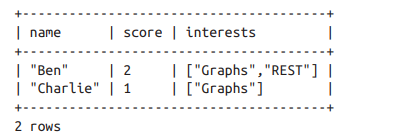

In [ ]:
MATCH (subject:User {name:{name}})
MATCH (subject)-[:INTERESTED_IN]->(interest:Topic)
 <-[:INTERESTED_IN]-(person:User),
 (person)-[:WORKS_FOR]->(company:Company)
RETURN person.name AS name,
 company.name AS company,
 count(interest) AS score,
 collect(interest.name) AS interests
ORDER BY score DESC

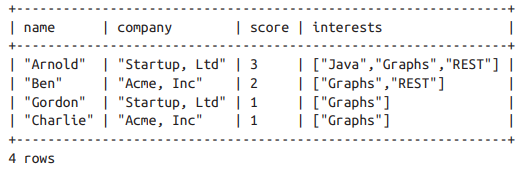

In [ ]:
MATCH (subject:User {name:{name}})
MATCH p=(subject)-[:WORKED_ON]->(:Project)-[:WORKED_ON*0..2]-(:Project)<-[:WORKED_ON]-(person:User)-[:INTERESTED_IN]->(interest:Topic)
WHERE person<>subject AND interest.name IN {interests}
WITH person, interest, min(length(p)) as pathLength
ORDER BY interest.name
RETURN person.name AS name,
 count(interest) AS score,
 collect(interest.name) AS interests,
 ((pathLength - 1)/2) AS distance
ORDER BY score DESC
LIMIT {resultLimit}

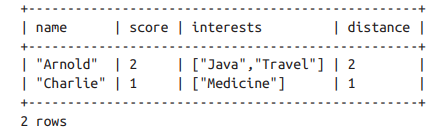

### Adding WORKED_WITH relationships

MATCH (subject:User {name:{name}})
MATCH (subject)-[:WORKED_ON]->()<-[:WORKED_ON]-(person:User)
WHERE NOT((subject)-[:WORKED_WITH]-(person))
WITH DISTINCT subject, person
CREATE UNIQUE (subject)-[:WORKED_WITH]-(person)
RETURN subject.name AS startName, person.name AS endName


### Authorization and Access Control

In [ ]:
MATCH (subject:User {name:{name}})
MATCH p=(subject)-[:WORKED_WITH*0..1]-(:Person)-[:WORKED_WITH]-(person:User)
 -[:INTERESTED_IN]->(interest:Topic)
WHERE person<>subject AND interest.name IN {interests}
WITH person, interest, min(length(p)) as pathLength
RETURN person.name AS name,
 count(interest) AS score,
 collect(interest.name) AS interests,
 (pathLength - 1) AS distance
ORDER BY score DESC
LIMIT {resultLimit}

### Authorization and Access Control

In [ ]:
MATCH (admin:Admin {name:{adminName}})
MATCH paths=(admin)-[:MEMBER_OF]->(:Group)-[:ALLOWED_INHERIT]->(:Company)
 <-[:CHILD_OF*0..3]-(company:Company)<-[:WORKS_FOR]-(employee:Employee)
 -[:HAS_ACCOUNT]->(account:Account)
WHERE NOT ((admin)-[:MEMBER_OF]->(:Group)
 -[:DENIED]->(:Company)<-[:CHILD_OF*0..3]-(company))
RETURN employee.name AS employee, account.name AS account
UNION
MATCH (admin:Admin {name:{adminName}})
MATCH paths=(admin)-[:MEMBER_OF]->(:Group)-[:ALLOWED_DO_NOT_INHERIT]->(:Company)
 <-[:WORKS_FOR]-(employee:Employee)-[:HAS_ACCOUNT]->(account:Account)
RETURN employee.name AS employee, account.name AS account


###Determining whether an administrator has access to a resource

In [ ]:
MATCH (admin:Admin {name:{adminName}}),
 (company:Company)-[:WORKS_FOR|HAS_ACCOUNT*1..2]
 -(resource:Resource {name:{resourceName}})
MATCH p=(admin)-[:MEMBER_OF]->(:Group)-[:ALLOWED_INHERIT]->(:Company)
 <-[:CHILD_OF*0..3]-(company)
WHERE NOT ((admin)-[:MEMBER_OF]->(:Group)-[:DENIED]->(:Company)
 <-[:CHILD_OF*0..3]-(company))
RETURN count(p) AS accessCount
UNION
MATCH (admin:Admin {name:{adminName}}),
 (company:Company)-[:WORKS_FOR|HAS_ACCOUNT*1..2]
 -(resource:Resource {name:{resourceName}})
MATCH p=(admin)-[:MEMBER_OF]->()-[:ALLOWED_DO_NOT_INHERIT]->(company)
RETURN count(p) AS accessCount

### Finding administrators for an account


In [ ]:
MATCH (resource:Resource {name:{resourceName}})
MATCH p=(resource)-[:WORKS_FOR|HAS_ACCOUNT*1..2]-(company:Company)
 -[:CHILD_OF*0..3]->()<-[:ALLOWED_INHERIT]-()<-[:MEMBER_OF]-(admin:Admin)
WHERE NOT ((admin)-[:MEMBER_OF]->(:Group)-[:DENIED]->(:Company)
 <-[:CHILD_OF*0..3]-(company))
RETURN admin.name AS admin
UNION
MATCH (resource:Resource {name:{resourceName}})
MATCH p=(resource)-[:WORKS_FOR|HAS_ACCOUNT*1..2]-(company:Company)
 <-[:ALLOWED_DO_NOT_INHERIT]-(:Group)<-[:MEMBER_OF]-(admin:Admin)
RETURN admin.name AS admin
